In [1]:
casa = False

In [2]:
from importlib.resources import files

data_root = files("zjet_corrections") / "corrections" / "pu"
print(any(p.name == "puWeights.json.gz" for p in data_root.rglob("puWeights.json.gz")))


True


In [3]:
from zjet_corrections.corrections import debug_jec_weightset
debug_jec_weightset('2018', mode='AK8', is_data=False)

{'path': '/tmp/tmp64flkypp/Summer19UL18_V5_MC_L1FastJet_AK8PFPuppi.jec.txt',
 'resource_exists': True,
 'evaluator_keys': ['Summer19UL18_V5_MC_L1FastJet_AK8PFPuppi']}

In [4]:
# def _ensure_import(modname: str, pip_spec: str = None, tag: str = None, extra_pip_args=()):
#     """
#     Try to import `modname`. If it fails, pip-install `pip_spec` into /tmp cache,
#     add to sys.path, and import again. `tag` is used to make the cache path deterministic.
#     """
#     try:
#         return __import__(modname)
#     except ImportError:
#         pass

#     base = os.environ.get("ZJET_CACHE_BASE", "/tmp/zjet_pkgs")
#     tag = tag or modname
#     target = os.path.join(base, tag.replace("/", "_"))
#     os.makedirs(target, exist_ok=True)

#     # crude file lock so many workers don't fight (best-effort)
#     lock = os.path.join(target, ".install.lock")
#     try:
#         fd = os.open(lock, os.O_CREAT | os.O_EXCL | os.O_WRONLY)
#         os.close(fd)
#         # We won the "lock": perform install if not already present
#         marker = os.path.join(target, ".done")
#         if not os.path.exists(marker):
#             cmd = [sys.executable, "-m", "pip", "install", "--no-deps", "-q", "--target", target, pip_spec]
#             if extra_pip_args:
#                 cmd[6:6] = list(extra_pip_args)
#             code = subprocess.call(cmd)
#             if code != 0:
#                 raise RuntimeError(f"pip install failed for {pip_spec} (exit {code})")
#             # mark success
#             with open(marker, "w") as f:
#                 f.write("ok")
#     except FileExistsError:
#         # someone else is installing; wait briefly
#         import time
#         for _ in range(120):
#             if os.path.exists(os.path.join(target, ".done")):
#                 break
#             time.sleep(0.5)
#     finally:
#         try:
#             os.remove(lock)
#         except OSError:
#             pass

#     if target not in sys.path:
#         sys.path.insert(0, target)
#     return __import__(modname)

In [5]:
import coffea
import numpy as np
import awkward as ak
from dask.distributed import Client
import uproot
import pickle
import os, sys, subprocess, json, gzip, correctionlib
import time
#sys.path.append(os.path.join(os.getcwd(), "src/zjet_corrections"))
import sys, os
sys.path.insert(0, os.path.abspath("/work")) 
import importlib
#zjet_corrections = _ensure_import("zjet_corrections")
import zjet_corrections.zjet_processor

importlib.reload(zjet_corrections.zjet_processor)

from zjet_corrections.zjet_processor import QJetMassProcessor
from coffea.nanoevents import NanoAODSchema
from coffea import processor


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
def format_time(seconds):
    hours, remainder = divmod(int(seconds), 3600)
    minutes, seconds = divmod(remainder, 60)
    if hours:
        return f"{hours}h {minutes}m {seconds}s"
    elif minutes:
        return f"{minutes}m {seconds}s"
    else:
        return f"{seconds}s"

In [8]:
NanoAODSchema.warn_missing_crossrefs = False



def make_runner(
    use_dask: bool = False,
    client=None,
    workers: int = 1,
    chunksize: int = 400_000,
    maxchunks: int | None = 1,
    skipbadfiles: bool = True,
):
    """
    If use_dask=True, 'client' must be an existing distributed.Client.
    Otherwise falls back to FuturesExecutor(workers=...).
    """
    if use_dask:
        if client is None:
            raise ValueError("use_dask=True but no Dask 'client' was provided.")
        executor = processor.DaskExecutor(
            client=client,
            status=True,      # progress bar
            retries=1,        # re-try failed chunks
        )
    else:
        executor = processor.FuturesExecutor(
            workers=workers,
            status=True,      # progress bar
            compression=None, # keep your original choice
        )

    return processor.Runner(
        executor=executor,
        schema=NanoAODSchema,
        chunksize=chunksize,
        maxchunks=maxchunks,
        skipbadfiles=skipbadfiles,
    )

# -------------------------
# Usage (Futures locally):
# -------------------------
# run = make_runner(use_dask=False, workers=1, chunksize=100000, maxchunks=None)
# out = run(fileset, "Events", processor_instance=ZmmMinimal())

In [9]:
os.getcwd()

'/work/ws/zjet_corrections'

In [10]:
os.getcwd()

'/work/ws/zjet_corrections'

In [11]:
prependstr = 'root://xcache/'
#prependstr = "root://cmsxrootd.fnal.gov/"
if casa:
    sample_path = 'samples.txt'
else:
    sample_path = '/work/ws/zjet_corrections/tests/samples.txt'
with open(sample_path) as f:
    lines = f.readlines()
files = []
for line in lines:
    files.append(prependstr + line[:-1])
fileset = {
    'DYJetsToLL_M-50': files

}

In [12]:
if casa:
    from dask.distributed import Client
    
    client = Client("tls://192.168.235.66:8786")
    client

In [13]:

# if casa:
#     client = Client("localhost:8786")
#     client

In [14]:
if casa:
    import shutil, os, pathlib

    pkg_dir = pathlib.Path("/home/cms-jovyan/new_git/zjet_corrections/src/zjet_corrections")   # or the actual path to your package dir
    zip_path = pathlib.Path("/tmp/zjet_corrections.zip")
    if zip_path.exists():
        zip_path.unlink()
    shutil.make_archive(zip_path.with_suffix(""), "zip", pkg_dir.parent, pkg_dir.name)

    client.upload_file(str(zip_path))  # uploads the zip and adds it to workers' sys.path
else:
    # client is already defined above, so nothing needs to be done here
    client = None

In [15]:
#client.run(debug_jec_weightset, '2018', mode='AK8', is_data=False)

In [59]:
#fileset_test = {"DYJets":["/work/ws/zjet_corrections/tests/DYjets.root"]}
if casa:
    fileset_test = {list(fileset.keys())[0]:[fileset[list(fileset.keys())[0]][3]]}

else:
    fileset_test = {"DYJets":["/work/ws/zjet_corrections/tests/DYjets.root"]}

run = make_runner(use_dask=False, client=client, chunksize=400000, maxchunks=1)
t0 = time.time()
out = run(fileset_test, "Events", processor_instance=QJetMassProcessor(debug=True))
t1 = time.time()
print(f"Done Running, time taken {format_time(t1 - t0)}")

Output()

[INFO] Starting processing for dataset: DYJets and file: /work/ws/zjet_corrections/tests/DYjets.root
[DEBUG] Total events in chunk: 312853
[DEBUG] Jackknife resampling not enabled, processing all events together.
[DEBUG] Weights initialized
[INFO] Applying MET filters
[DEBUG] PU weights (nom, up, down) : [1.07586275 1.09341974 1.07586275 0.95621222 0.71529626 1.04339691
 0.91363198 0.58192506 0.82560876 0.69073923]


[DEBUG] pdf weights (nom, up, down) : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[DEBUG] L1 prefiring weights (nom, up, down) : [1, 0.999, 1, 0.996, 1, 1, 1, 0.998, 0.997, 1]


[DEBUG] Q2 weights (nom, up, down) : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[INFO] Entering GEN selection


/usr/local/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/usr/local/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


/usr/local/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


[INFO] Entering RECO selection
Using TAG AK8PFPuppi


[DEBUG] Processing jet systematic: nominal


[DEBUG] Padded Electron/Muon collections to minimum length 2 per event
[INFO] Lepton weights added
[DEBUG] Len of ptreco 57 mreco 57 syst nominal channel ee dataset DYJets
[DEBUG] ptreco sample [179, 256, 280, 269, 194, 171, 247, 183, 193, 255]
[DEBUG] mreco sample [47.6, 56.8, 73.1, 38.9, 20.2, 59, 37.5, 60.5, 24.4, 30.4]
[DEBUG] mreco_g sample [-1, 35.8, 65.8, 2.21, -1, -1, 17.7, -1, 6.68, 4.27]
[DEBUG] Len of ptreco 99 mreco 99 syst nominal channel mm dataset DYJets
[DEBUG] ptreco sample [209, 230, 173, 180, 176, 193, 181, 202, 194, 243]
[DEBUG] mreco sample [28.6, 32, 16.4, 26, 32.5, 21.5, 21.3, 22.4, 37.1, 59.2]
[DEBUG] mreco_g sample [6.21, 4.43, -1, -1, -1, 6.85, -1, 2.61, -1, 55.8]


[DEBUG] Processing jet systematic: JERUp
[DEBUG] Processing jet systematic: JERDown


[INFO] Scaled ptjet_mjet_u_reco for dataset DYJets by 1160.459138 = 6077.22 * 59740.0 / 312853.0
[INFO] Scaled ptjet_mjet_g_reco for dataset DYJets by 1160.459138 = 6077.22 * 59740.0 / 312853.0
[INFO] Scaled ptjet_mjet_u_gen for dataset DYJets by 1160.459138 = 6077.22 * 59740.0 / 312853.0
[INFO] Scaled ptjet_mjet_g_gen for dataset DYJets by 1160.459138 = 6077.22 * 59740.0 / 312853.0
[INFO] Scaled response_matrix_u for dataset DYJets by 1160.459138 = 6077.22 * 59740.0 / 312853.0
[INFO] Scaled response_matrix_g for dataset DYJets by 1160.459138 = 6077.22 * 59740.0 / 312853.0
Done Running, time taken 19s


(0.0, 200.0)

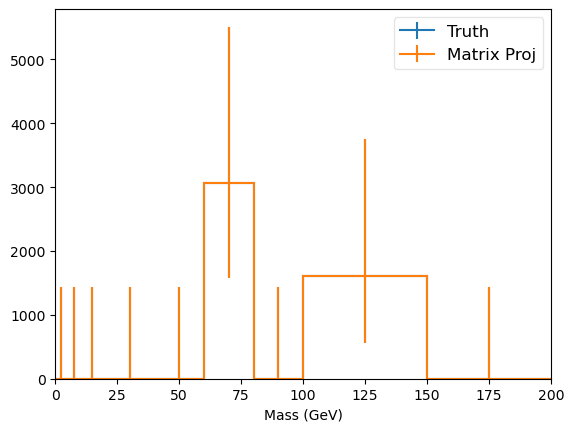

In [60]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_u_gen'][{"systematic":"nominal"}].project('ptgen','mgen')[2,hist.rebin(1)]
h2 = out['response_matrix_u'][{"systematic":"nominal"}].project('ptgen','mgen')[2,hist.rebin(1)]
h1.plot(label='Truth')
h2.plot(label='Matrix Proj')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.0, 200.0)

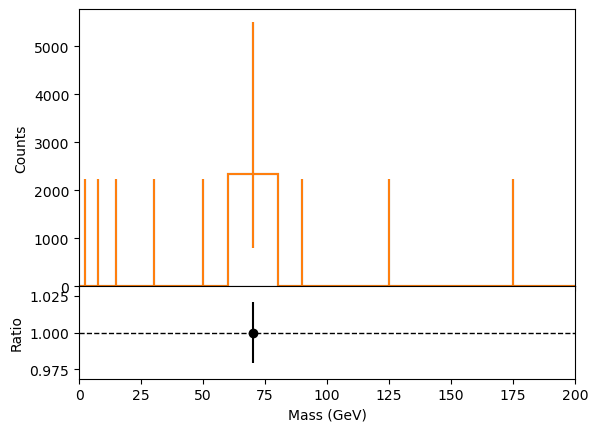

In [56]:
h2.plot_ratio(h1)
plt.xlim(0,200)

(0.0, 200.0)

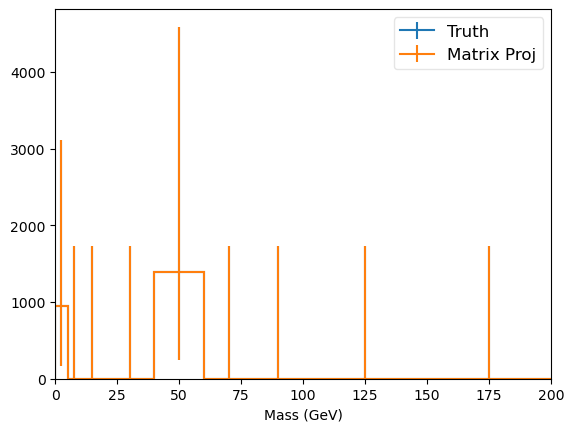

In [57]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_g_gen'][{"systematic":"nominal"}].project('ptgen','mgen')[2,hist.rebin(1)]
h2 = out['response_matrix_g'][{"systematic":"nominal"}].project('ptgen','mgen')[2,hist.rebin(1)]
h1.plot(label='Truth')
h2.plot(label='Matrix Proj')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.0, 200.0)

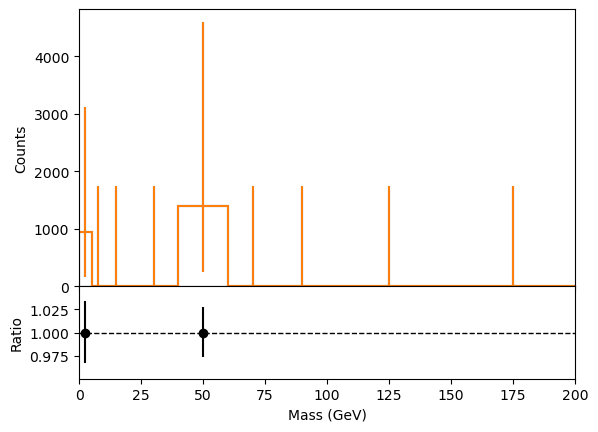

In [58]:
h2.plot_ratio(h1)
plt.xlim(0,200)

In [112]:
out['ptjet_mjet_u_reco'][{"systematic":"nominal"}].project('ptreco').values(flow = True)


array([60052.33491913, 65593.55569195, 14166.36578428,  5375.99318195,
           0.        ])

In [113]:
out['response_matrix_u'][{"systematic":"nominal"}].project('ptgen','ptreco').values(flow = True)[1:, :].sum(axis = 0)

array([ 5386.76898553, 45464.24782999, 13911.93100271,  5265.61151838,
           0.        ])

(0.0, 200.0)

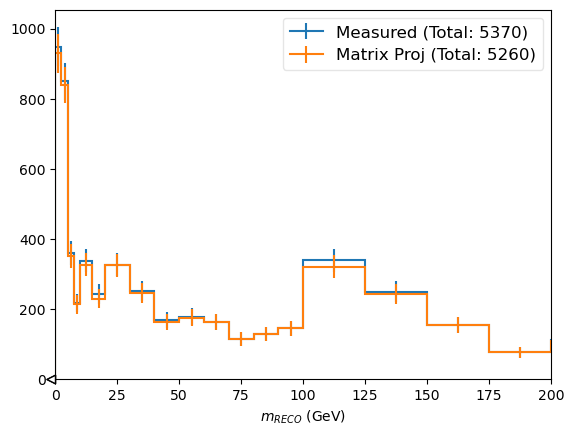

In [115]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_g_reco'][{"systematic":"nominal"}].project('ptreco','mreco')[2,hist.rebin(1)]
h2 = out['response_matrix_g'][{"systematic":"nominal"}].project('ptreco','mreco')[2,hist.rebin(1)]
h1.plot(label='Measured')
h2.plot(label='Matrix Proj')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Measured':
        new_labels.append(f"Measured (Total: {total_reco:.0f})")
    elif lab == 'Matrix Proj':
        new_labels.append(f"Matrix Proj (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.0, 200.0)

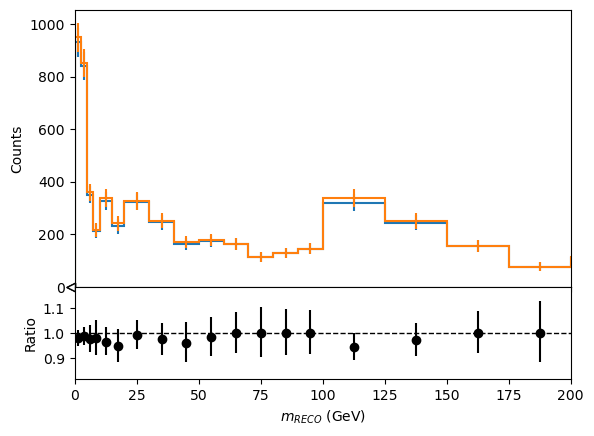

In [116]:
h2.plot_ratio(h1)
plt.xlim(0,200)

(0.0, 200.0)

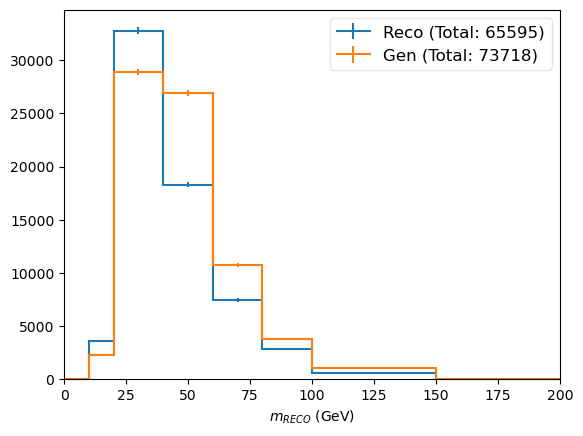

In [35]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_u_reco'][{"systematic":"nominal"}].project('ptreco','mreco')[0,hist.rebin(2)]
h2 = out['ptjet_mjet_u_gen'][{"systematic":"nominal"}].project('ptgen','mgen')[0,hist.rebin(1)]
h1.plot(label='Reco')
h2.plot(label='Gen')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

(0.0, 200.0)

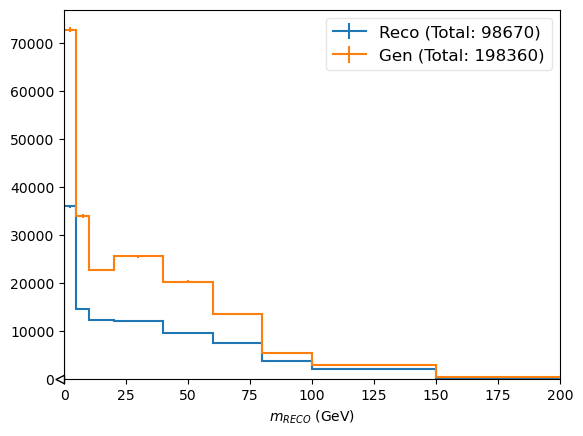

In [36]:
import hist
import matplotlib.pyplot as plt
h1 = out['ptjet_mjet_g_reco'][{"systematic":"nominal"}].project('mreco')[hist.rebin(2)]
h2 = out['ptjet_mjet_g_gen'][{"systematic":"nominal"}].project('mgen')[hist.rebin(1)]
h1.plot(label='Reco')
h2.plot(label='Gen')
plt.legend()
total_reco = h1.sum().value
total_gen = h2.sum().value
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for lab in labels:
    if lab == 'Reco':
        new_labels.append(f"Reco (Total: {total_reco:.0f})")
    elif lab == 'Gen':
        new_labels.append(f"Gen (Total: {total_gen:.0f})")
    else:
        new_labels.append(lab)
ax.legend(handles, new_labels, loc='best', fontsize=12, framealpha=0.5)
#plt.yscale('log')
plt.xlim(0,200)

In [37]:
out['response_matrix_g']

Hist(
  StrCategory(['DYJetsToLL_M-50'], growth=True, name='dataset', label='Primary dataset'),
  StrCategory(['SingleMuon'], growth=True, name='channel', label='Channel'),
  Variable([200, 290, 400, 13000], name='ptreco', label='$p_{T,RECO}$ (GeV)'),
  Variable([0, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200, 500, 1000], name='mreco', label='$m_{RECO}$ (GeV)'),
  Variable([200, 290, 400, 13000], name='ptgen', label='$p_{T,GEN}$ (GeV)'),
  Variable([0, 5, 10, 20, 40, 60, 80, 100, 150, 200, 1000], name='mgen', label='Mass (GeV)'),
  StrCategory(['nominal', 'puUp', 'puDown', 'pdfUp', 'pdfDown', 'l1prefiringUp', 'l1prefiringDown', 'JERUp', 'JERDown'], growth=True, name='systematic', label='Systematic Uncertainty'),
  storage=Weight()) # Sum: WeightedSum(value=717480, variance=2.73591e+06) (WeightedSum(value=1.60428e+06, variance=6.11745e+06) with flow)

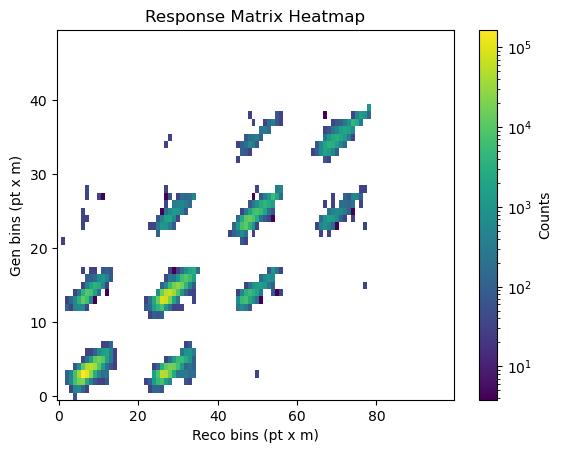

In [54]:
h_resp = out['response_matrix_u'].project('ptgen', 'mgen', 'ptreco', 'mreco')
resp_vals = h_resp.values(flow = True)
resp_vals = resp_vals[:, 1:-1, :, 1:-1] #removing flow from mass
resp_vals_2d = resp_vals.reshape(resp_vals.shape[0]*resp_vals.shape[1], resp_vals.shape[2]*resp_vals.shape[3])
plt.imshow(resp_vals_2d, origin='lower', aspect='auto', cmap='viridis', norm = 'log')
plt.colorbar(label='Counts')
plt.xlabel('Reco bins (pt x m)')
plt.ylabel('Gen bins (pt x m)')
plt.title('Response Matrix Heatmap')
plt.show()

In [39]:
resp_vals.sum(axis= (0,1,3))

array([664213.38099872, 725301.16805286, 155873.00071236,  58887.55901854,
            0.        ])

In [117]:
import pickle
with open("test_output.pkl", "wb") as f:
    pickle.dump(out, f)
print(f"Output written to test_output.pkl with size {os.path.getsize('test_output.pkl')/1e3:.1f} KB")

Output written to test_output.pkl with size 1952.1 KB


In [118]:
!cp test_output.pkl working.pkl